In [61]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [62]:

def process_folder(folder_path, receiver_column, producer_column,decay):
    # List only .xlsx files in the folder
    excel_files = [f for f in os.listdir(folder_path) if f.endswith('.xlsx')]
    if not excel_files:
        print(f'No Excel files found in folder: {folder_path}')
        return None, None

    # Initialize sets for extracting all unique concentrations from filenames
    xylose_concentrations = set()
    iptg_concentrations = set()
    # Regex pattern matches e.g. Xylose2_50IPTG_cropped_cell_info.xlsx
    pattern = r'Xylose(\w+)_([\w]+)IPTG_cropped_cell_info\.xlsx'

    # Parse concentrations from filenames
    for filename in excel_files:
        match = re.match(pattern, filename)
        if match:
            xylose_concentrations.add(match.group(1))
            iptg_concentrations.add(match.group(2))
        else:
            print(f'Filename {filename} does not match expected pattern')

    print(f'Found {len(xylose_concentrations)} xylose concentrations:', ', '.join(xylose_concentrations))
    print(f'Found {len(iptg_concentrations)} IPTG concentrations:', ', '.join(iptg_concentrations))

    # Prepare to collect all (frequency, intensity) data and condition names
    all_frequency_data = []
    all_intensity_data = []
    conditions = []

    # For each combination of xylose and IPTG concentrations
    for xylose in xylose_concentrations:
        for iptg in iptg_concentrations:
            current_filename = f'Xylose{xylose}_{iptg}IPTG_cropped_cell_info.xlsx'
            full_path = os.path.join(folder_path, current_filename)
            if not os.path.exists(full_path):
                print(f'File {current_filename} not found, skipping...')
                continue
            print(f'Reading data from {full_path}')
            df = pd.read_excel(full_path, engine='openpyxl')

            num_cols = df.shape[1]
            # Frame numbers are assumed to be in the first column (index 0)
            frames = df.iloc[:, 0].unique()

            # Coordinates and cell type
            x_coords = df.iloc[:, 1].values
            y_coords = df.iloc[:, 2].values
            cell_type = df.iloc[:, num_cols-1].values  # Last column is cell type

            # Receiver intensities (column chosen by user)
            receiver_intensity = df.iloc[:, receiver_column].values   #concentration of rfp

            # Identify cells by their type
            receiver_cells = np.where(cell_type == 0)[0]  # 0 = receiver in this code 
            sender_cells = np.where(cell_type == 1)[0]    # 1 = sender/producer in this code

            print(f'Found {len(receiver_cells)} receiver cells, {len(sender_cells)} sender cells in all frames')

            decay_constant = decay
            neighborhood_radius = decay_constant  

            # Process each frame separately
            for frame in frames:
                frame_indices = np.where(df.iloc[:, 0].values == frame)[0]
                # Find receiver and sender cells present in this frame
                receiver_cells_in_frame = np.intersect1d(receiver_cells, frame_indices)
                sender_cells_in_frame = np.intersect1d(sender_cells, frame_indices)

            
                if len(receiver_cells_in_frame) == 0:
                    print("No receivers found!!")
                    continue

                # Coordinates for sender/receiver cells in this frame
                sender_points = np.column_stack((x_coords[sender_cells_in_frame], y_coords[sender_cells_in_frame]))
                receiver_points = np.column_stack((x_coords[receiver_cells_in_frame], y_coords[receiver_cells_in_frame]))

                # 1. Pairwise distances sender -> receiver
                if sender_points.shape[0] > 0:
                  
                    distances_sender_to_receiver = np.linalg.norm(sender_points[:, None, :] - receiver_points[None, :, :], axis=2) #shape (n,m)
                    exponential_weighted_senders = np.sum(np.exp(-distances_sender_to_receiver / neighborhood_radius), axis=0)
                    #exponential_weighted_senders = np.sum(neighborhood_radius/(distances_sender_to_receiver+neighborhood_radius) , axis=0)

                else:
                    exponential_weighted_senders = np.zeros(receiver_points.shape[0])

                # 2. Pairwise distances receiver -> receiver (self and others)
                distances_receiver_to_receiver = np.linalg.norm(receiver_points[:, None, :] - receiver_points[None, :, :], axis=2)
                exponential_weighted_receivers = np.sum(np.exp(-distances_receiver_to_receiver / neighborhood_radius), axis=0)
                #exponential_weighted_receivers = np.sum(neighborhood_radius/(distances_receiver_to_receiver+neighborhood_radius), axis=0)

                # 3. Calculate frequencies and intensities
                frequency = exponential_weighted_senders / (exponential_weighted_senders + exponential_weighted_receivers)
                intensity = receiver_intensity[receiver_cells_in_frame]
      
                # 4. Filter for valid (frequency>0 and intensity>0)
                valid_indices = (frequency > 0) & (intensity > 0)

                if np.sum(valid_indices) > 0:
                    all_frequency_data.extend(frequency[valid_indices])
                    all_intensity_data.extend(intensity[valid_indices])

            conditions.append(f'Xylose{xylose}_IPTG{iptg}')
            print(f'Processed condition: Xylose {xylose}, IPTG {iptg}')

    print('Total valid datapoints collected:', len(all_frequency_data))
    return {'frequency': np.array(all_frequency_data), 'intensity': np.array(all_intensity_data)}, conditions


In [ ]:
def create_single_heatmap_log(data, conditions, folder_path,scale):
    print('\n=== Y-axis Limit Selection (Logarithmic Scale) ===')
    print(f'Dataset intensity range: {data["intensity"].min():.1f} to {data["intensity"].max():.1f}')
    y_limit_log = float(4)

    plt.rcParams.update({'font.size': 24,  'lines.linewidth': 2, 'axes.linewidth': 2})

    plt.figure(figsize=(12,9))
    print(f'Using logarithmic Y-limit: 10^{y_limit_log:.1f}')

    n_bins_x = 80
    n_bins_y = 80
    x_edges = np.logspace(np.log10(0.01), np.log10(1), n_bins_x + 1)
    y_edges = np.logspace(np.log10(10**1), np.log10(10**y_limit_log), n_bins_y + 1)
    x_centers = np.sqrt(x_edges[:-1] * x_edges[1:])
    y_centers = np.sqrt(y_edges[:-1] * y_edges[1:])

    N, _, _ = np.histogram2d(data['frequency'], data['intensity'], bins=[x_edges, y_edges])

    # Normalize column-wise (each X-bin)
    N_normalized = np.zeros_like(N)
    for col in range(N.shape[0]):
        max_val = N[col, :].max()
        if max_val > 0:
            N_normalized[col, :] = N[col, :] / max_val

    from matplotlib.colors import LogNorm
    plt.imshow(N_normalized.T, extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]],
            aspect='auto', origin='lower', cmap='viridis')


    """ plt.xscale('log')
    plt.yscale('log') """
    plt.xlim(0.01, 1)
    plt.ylim(0, 10**y_limit_log)
    #plt.xticks([0.01, 0.032, 0.1, 0.32, 1.0], ['0.01', '0.032', '0.1', '0.32', '1.0'])
    plt.xlabel('Producer Frequency')
    plt.ylabel('Intensity (a.u.)')
    plt.title(scale)
    cbar = plt.colorbar()
    cbar.set_label('Relative Density per Frequency Bin')
    cbar.ax.tick_params(labelsize=22)
    plt.grid(alpha=0.3)
    plt.box(True)
    plt.tick_params(direction='out', length=8)
    plt.tight_layout()

    folder_name = os.path.basename(folder_path)
    filename = f'SingleHeatmapLog_Poster_{folder_name}.png'
    plt.savefig(filename, dpi=600)
    print(f'Saved poster-ready single logarithmic heatmap: {filename}')
    plt.show()



Found 1 xylose concentrations: 1
Found 1 IPTG concentrations: 1
Reading data from ./Xylose1_1IPTG_cropped_cell_info.xlsx
Found 26703 receiver cells, 28073 sender cells in all frames
Processed condition: Xylose 1, IPTG 1
Total valid datapoints collected: 26703

=== Y-axis Limit Selection (Logarithmic Scale) ===
Dataset intensity range: 14.1 to 596.5
Using logarithmic Y-limit: 10^4.0
Saved poster-ready single logarithmic heatmap: SingleHeatmapLog_Poster_..png


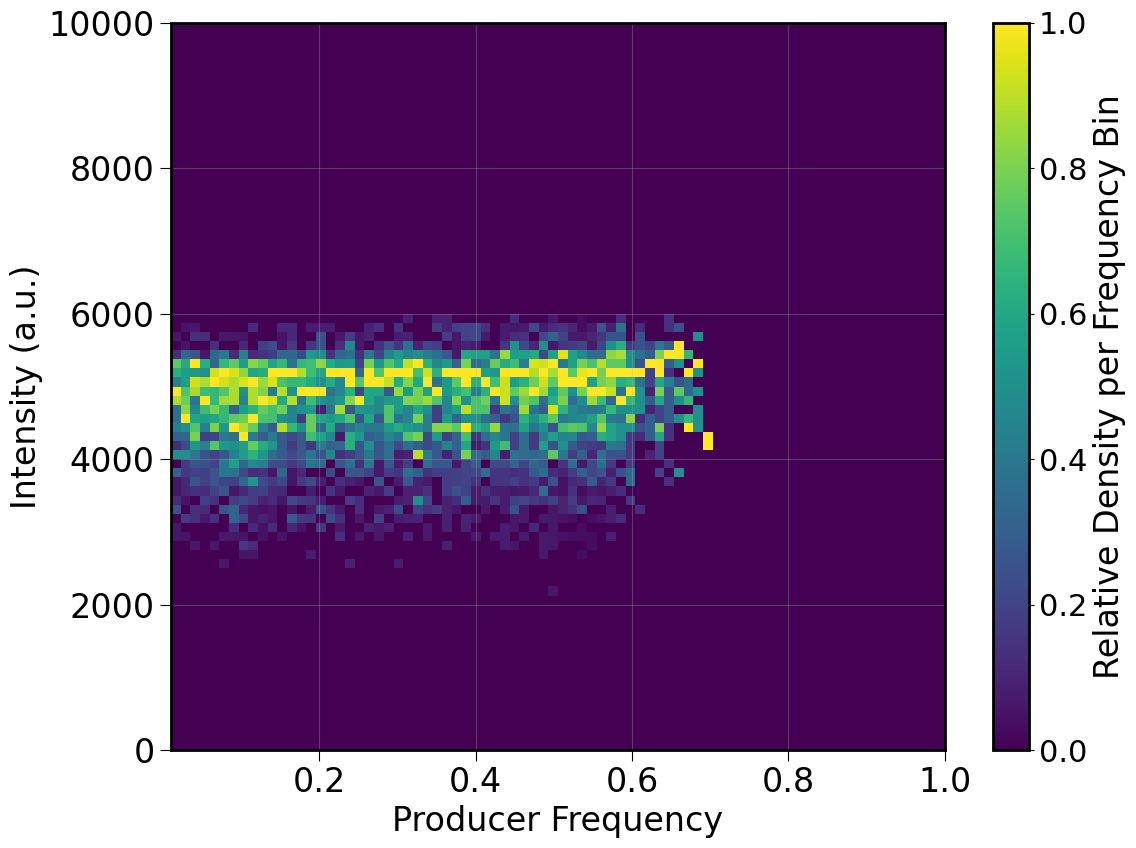

Found 1 xylose concentrations: 1
Found 1 IPTG concentrations: 1
Reading data from ./Xylose1_1IPTG_cropped_cell_info.xlsx
Found 26703 receiver cells, 28073 sender cells in all frames
Processed condition: Xylose 1, IPTG 1
Total valid datapoints collected: 26703

=== Y-axis Limit Selection (Logarithmic Scale) ===
Dataset intensity range: 14.1 to 596.5
Using logarithmic Y-limit: 10^4.0
Saved poster-ready single logarithmic heatmap: SingleHeatmapLog_Poster_..png


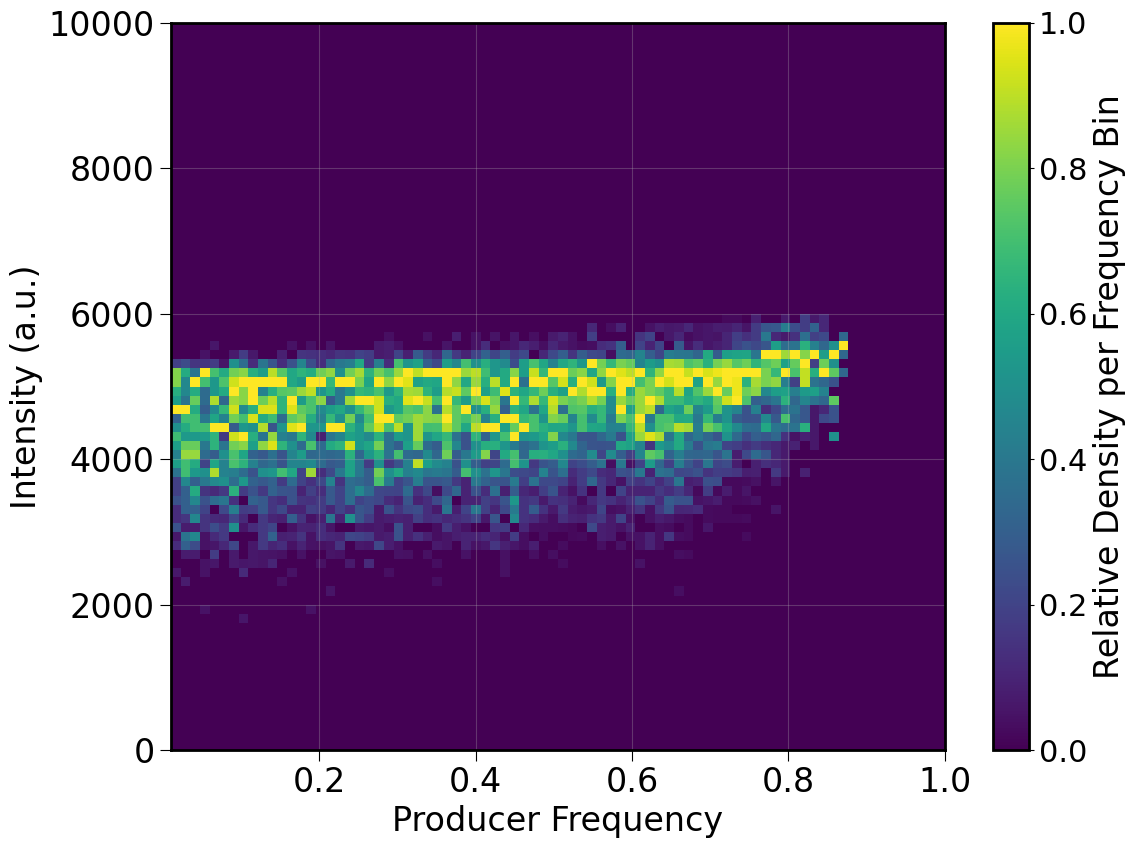

Found 1 xylose concentrations: 1
Found 1 IPTG concentrations: 1
Reading data from ./Xylose1_1IPTG_cropped_cell_info.xlsx
Found 26703 receiver cells, 28073 sender cells in all frames
Processed condition: Xylose 1, IPTG 1
Total valid datapoints collected: 26703

=== Y-axis Limit Selection (Logarithmic Scale) ===
Dataset intensity range: 14.1 to 596.5
Using logarithmic Y-limit: 10^4.0
Saved poster-ready single logarithmic heatmap: SingleHeatmapLog_Poster_..png


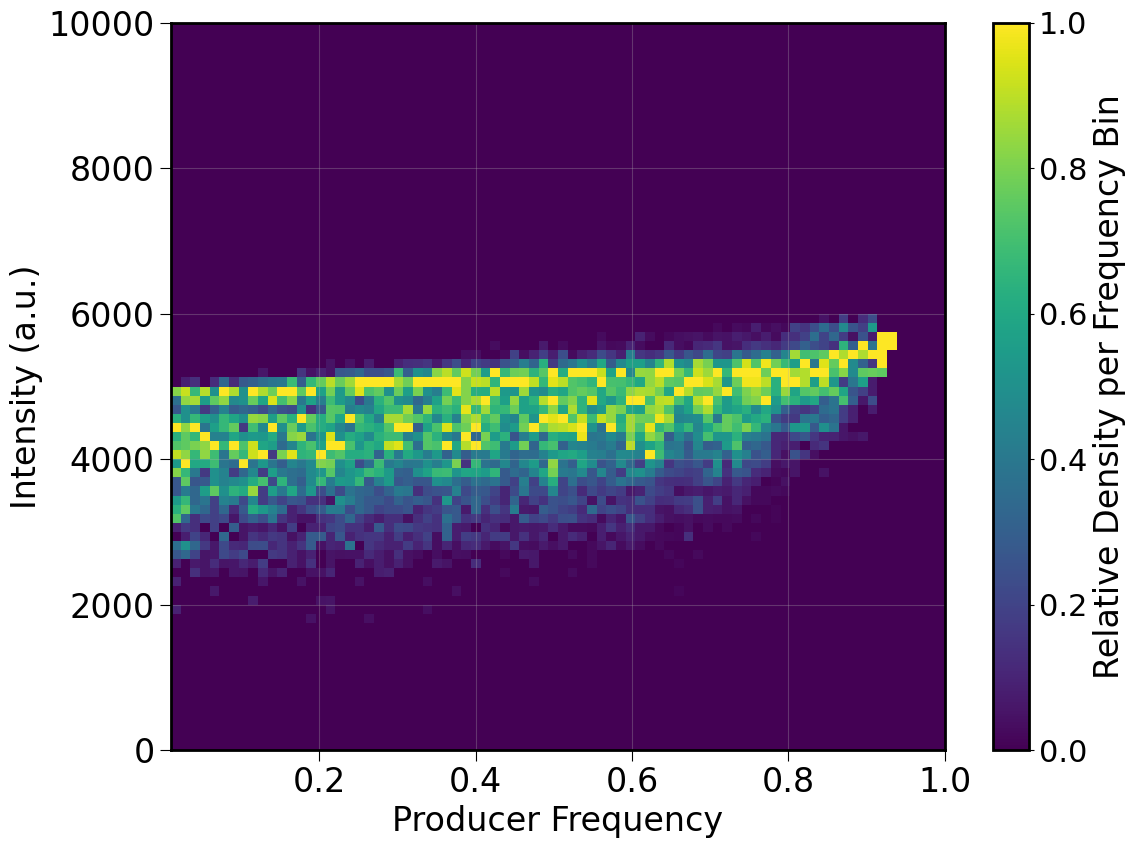

Found 1 xylose concentrations: 1
Found 1 IPTG concentrations: 1
Reading data from ./Xylose1_1IPTG_cropped_cell_info.xlsx
Found 26703 receiver cells, 28073 sender cells in all frames
Processed condition: Xylose 1, IPTG 1
Total valid datapoints collected: 26703

=== Y-axis Limit Selection (Logarithmic Scale) ===
Dataset intensity range: 14.1 to 596.5
Using logarithmic Y-limit: 10^4.0
Saved poster-ready single logarithmic heatmap: SingleHeatmapLog_Poster_..png


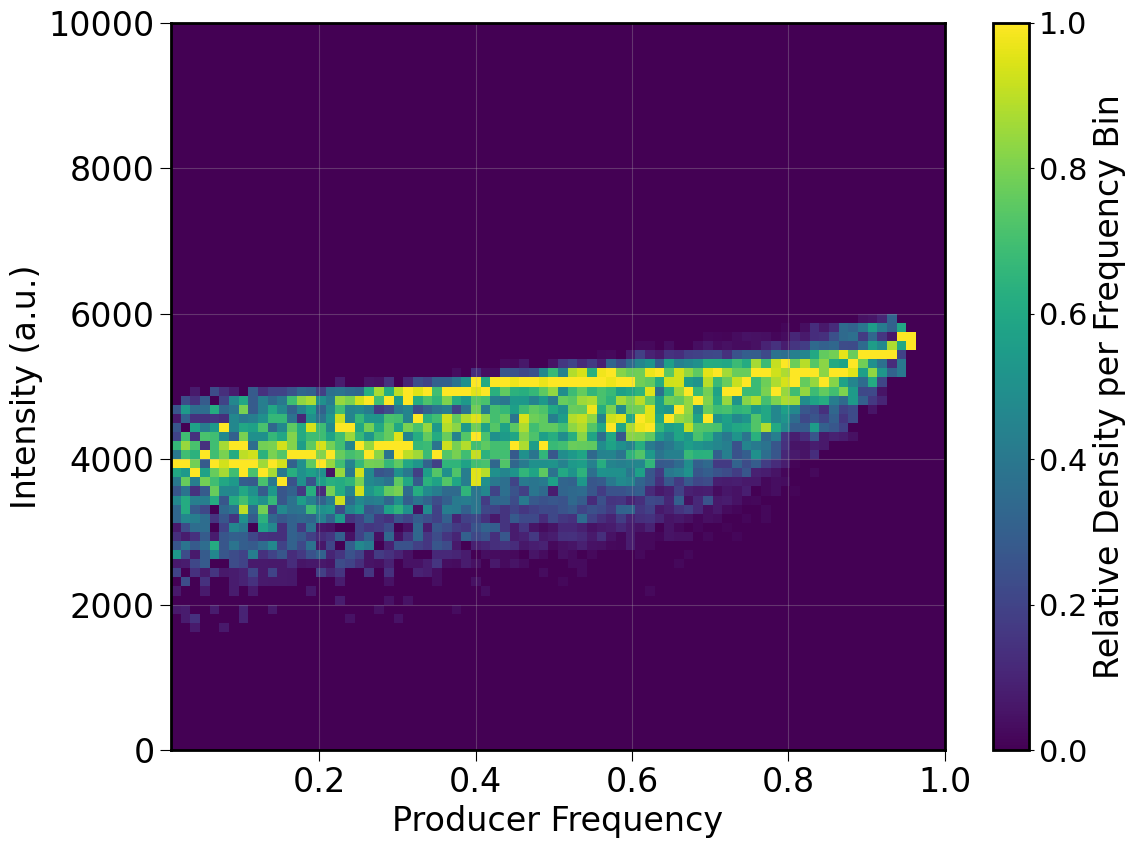

Found 1 xylose concentrations: 1
Found 1 IPTG concentrations: 1
Reading data from ./Xylose1_1IPTG_cropped_cell_info.xlsx
Found 26703 receiver cells, 28073 sender cells in all frames
Processed condition: Xylose 1, IPTG 1
Total valid datapoints collected: 26703

=== Y-axis Limit Selection (Logarithmic Scale) ===
Dataset intensity range: 14.1 to 596.5
Using logarithmic Y-limit: 10^4.0
Saved poster-ready single logarithmic heatmap: SingleHeatmapLog_Poster_..png


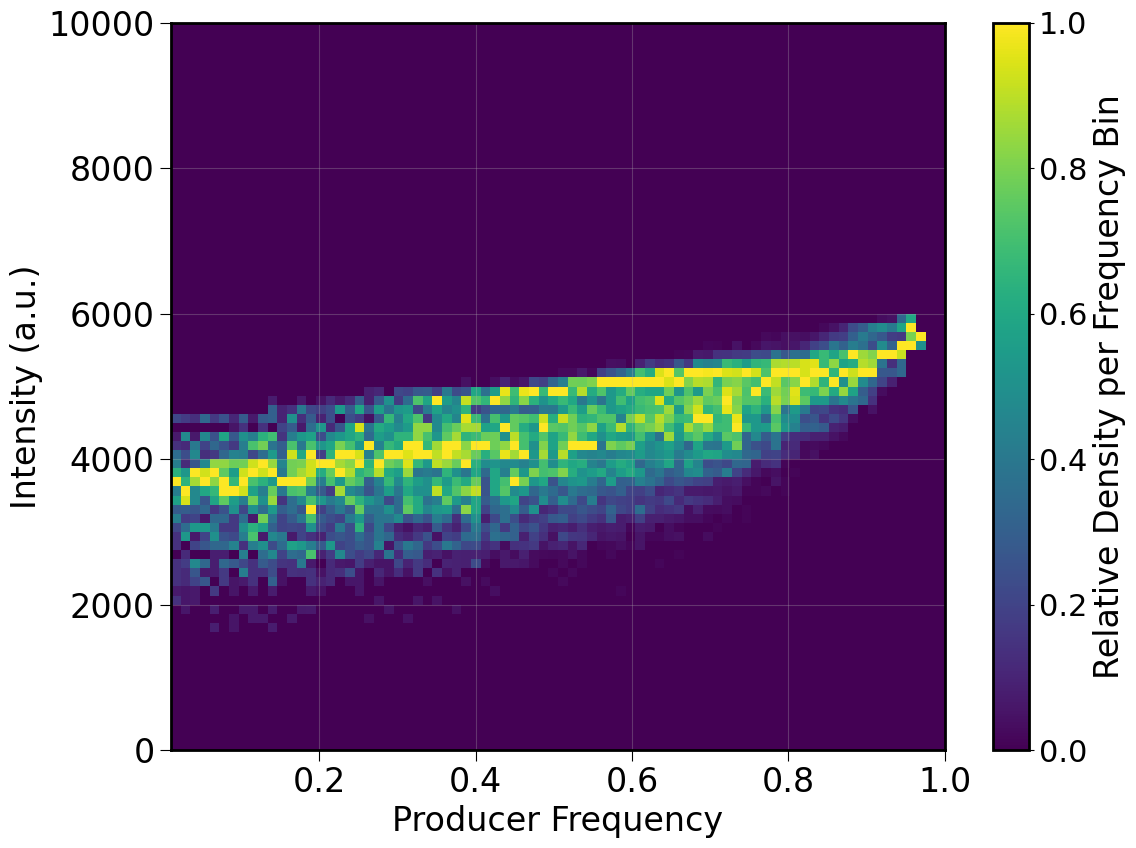

Found 1 xylose concentrations: 1
Found 1 IPTG concentrations: 1
Reading data from ./Xylose1_1IPTG_cropped_cell_info.xlsx
Found 26703 receiver cells, 28073 sender cells in all frames
Processed condition: Xylose 1, IPTG 1
Total valid datapoints collected: 26703

=== Y-axis Limit Selection (Logarithmic Scale) ===
Dataset intensity range: 14.1 to 596.5
Using logarithmic Y-limit: 10^4.0
Saved poster-ready single logarithmic heatmap: SingleHeatmapLog_Poster_..png


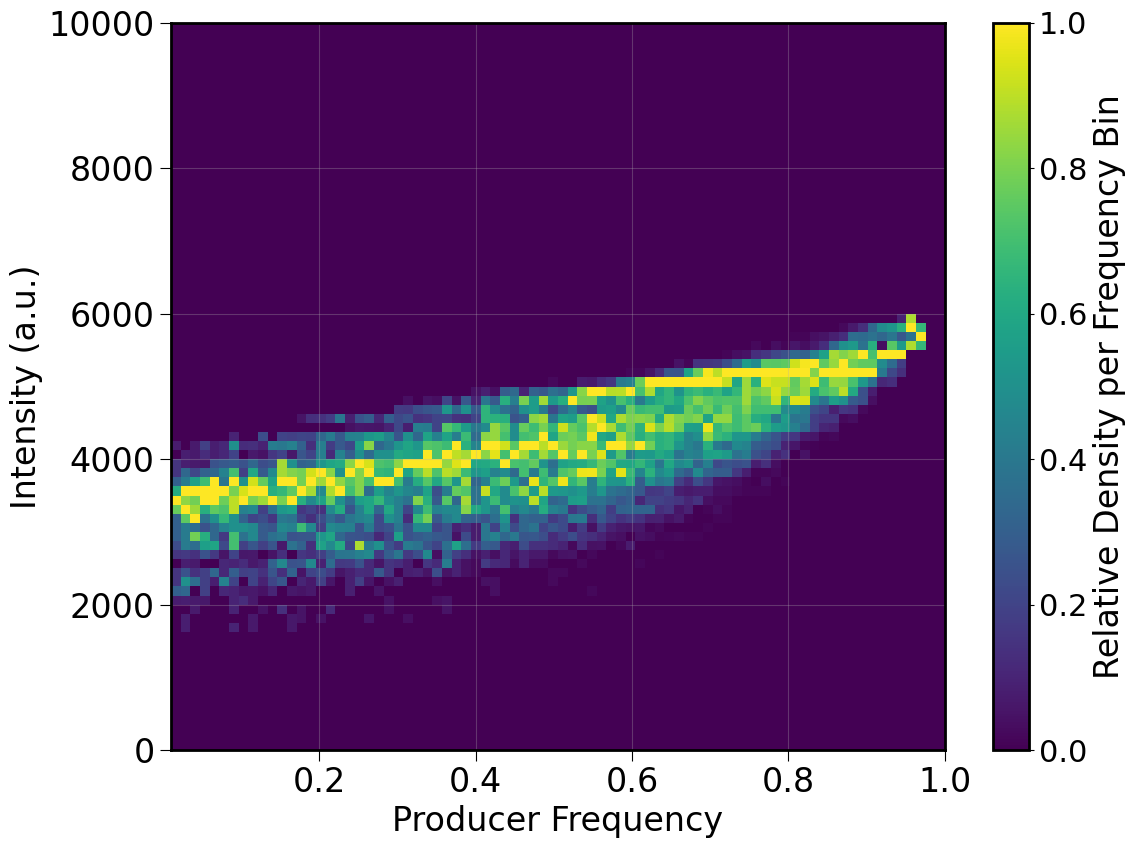

Found 1 xylose concentrations: 1
Found 1 IPTG concentrations: 1
Reading data from ./Xylose1_1IPTG_cropped_cell_info.xlsx
Found 26703 receiver cells, 28073 sender cells in all frames
Processed condition: Xylose 1, IPTG 1
Total valid datapoints collected: 26703

=== Y-axis Limit Selection (Logarithmic Scale) ===
Dataset intensity range: 14.1 to 596.5
Using logarithmic Y-limit: 10^4.0
Saved poster-ready single logarithmic heatmap: SingleHeatmapLog_Poster_..png


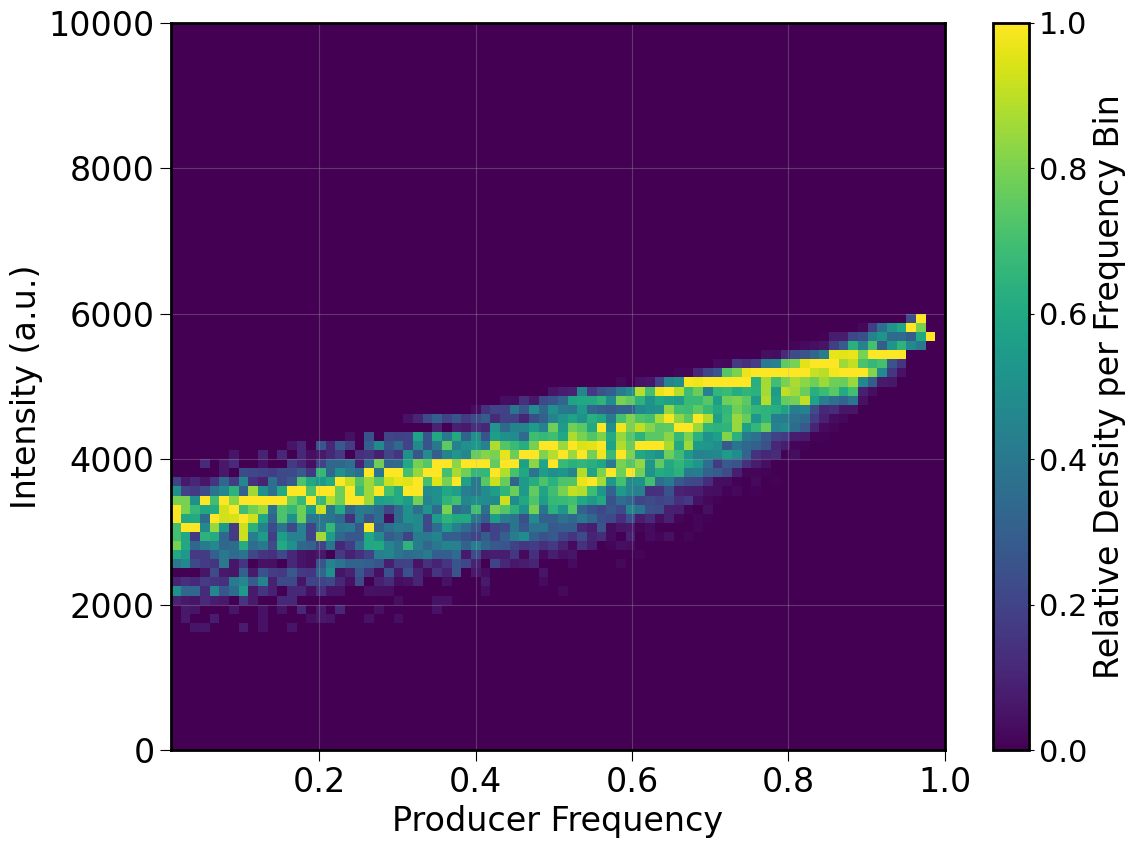

Found 1 xylose concentrations: 1
Found 1 IPTG concentrations: 1
Reading data from ./Xylose1_1IPTG_cropped_cell_info.xlsx
Found 26703 receiver cells, 28073 sender cells in all frames
Processed condition: Xylose 1, IPTG 1
Total valid datapoints collected: 26703

=== Y-axis Limit Selection (Logarithmic Scale) ===
Dataset intensity range: 14.1 to 596.5
Using logarithmic Y-limit: 10^4.0
Saved poster-ready single logarithmic heatmap: SingleHeatmapLog_Poster_..png


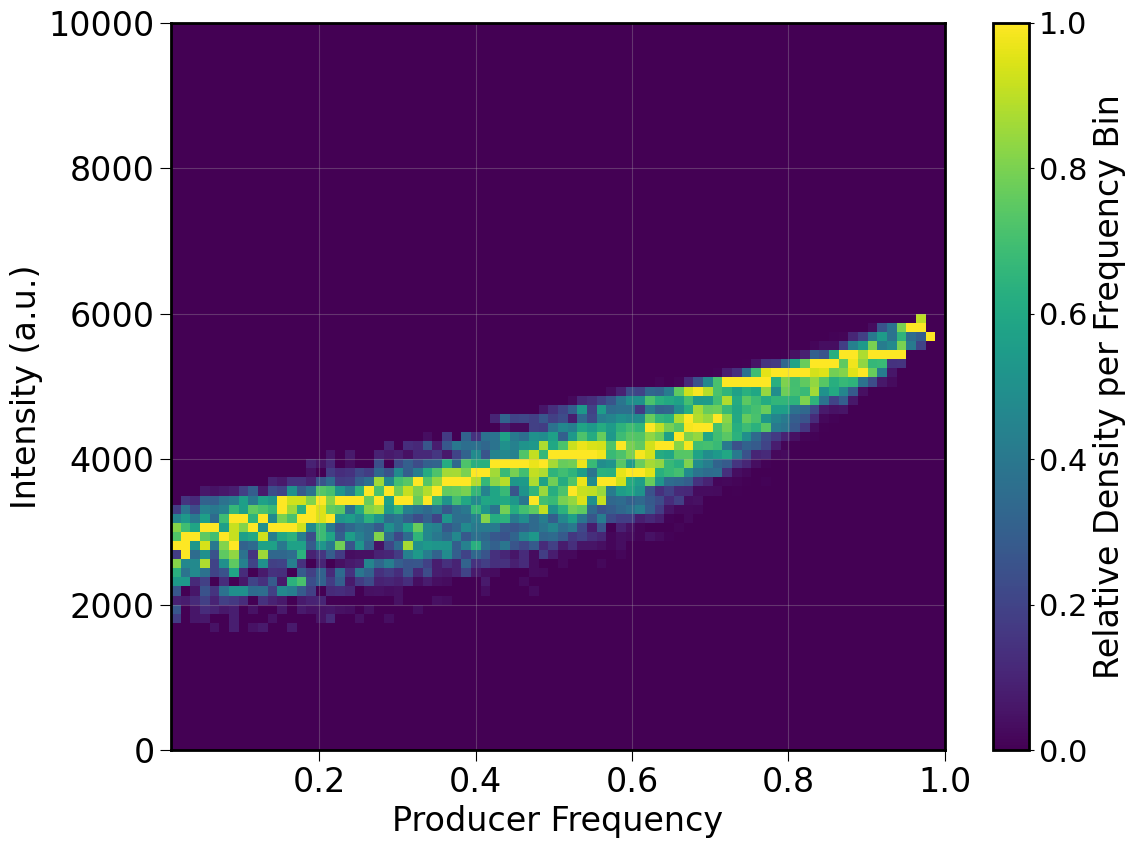

Found 1 xylose concentrations: 1
Found 1 IPTG concentrations: 1
Reading data from ./Xylose1_1IPTG_cropped_cell_info.xlsx
Found 26703 receiver cells, 28073 sender cells in all frames
Processed condition: Xylose 1, IPTG 1
Total valid datapoints collected: 26703

=== Y-axis Limit Selection (Logarithmic Scale) ===
Dataset intensity range: 14.1 to 596.5
Using logarithmic Y-limit: 10^4.0
Saved poster-ready single logarithmic heatmap: SingleHeatmapLog_Poster_..png


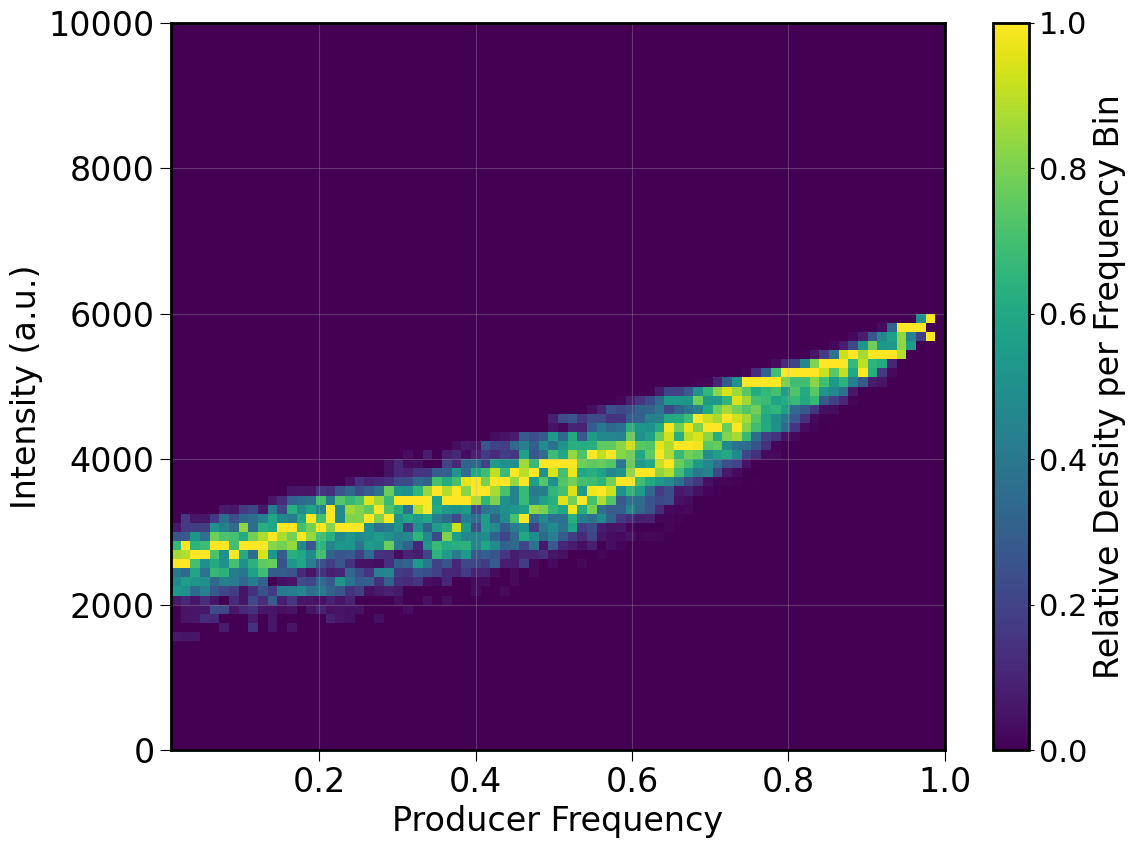

Found 1 xylose concentrations: 1
Found 1 IPTG concentrations: 1
Reading data from ./Xylose1_1IPTG_cropped_cell_info.xlsx
Found 26703 receiver cells, 28073 sender cells in all frames
Processed condition: Xylose 1, IPTG 1
Total valid datapoints collected: 26703

=== Y-axis Limit Selection (Logarithmic Scale) ===
Dataset intensity range: 14.1 to 596.5
Using logarithmic Y-limit: 10^4.0
Saved poster-ready single logarithmic heatmap: SingleHeatmapLog_Poster_..png


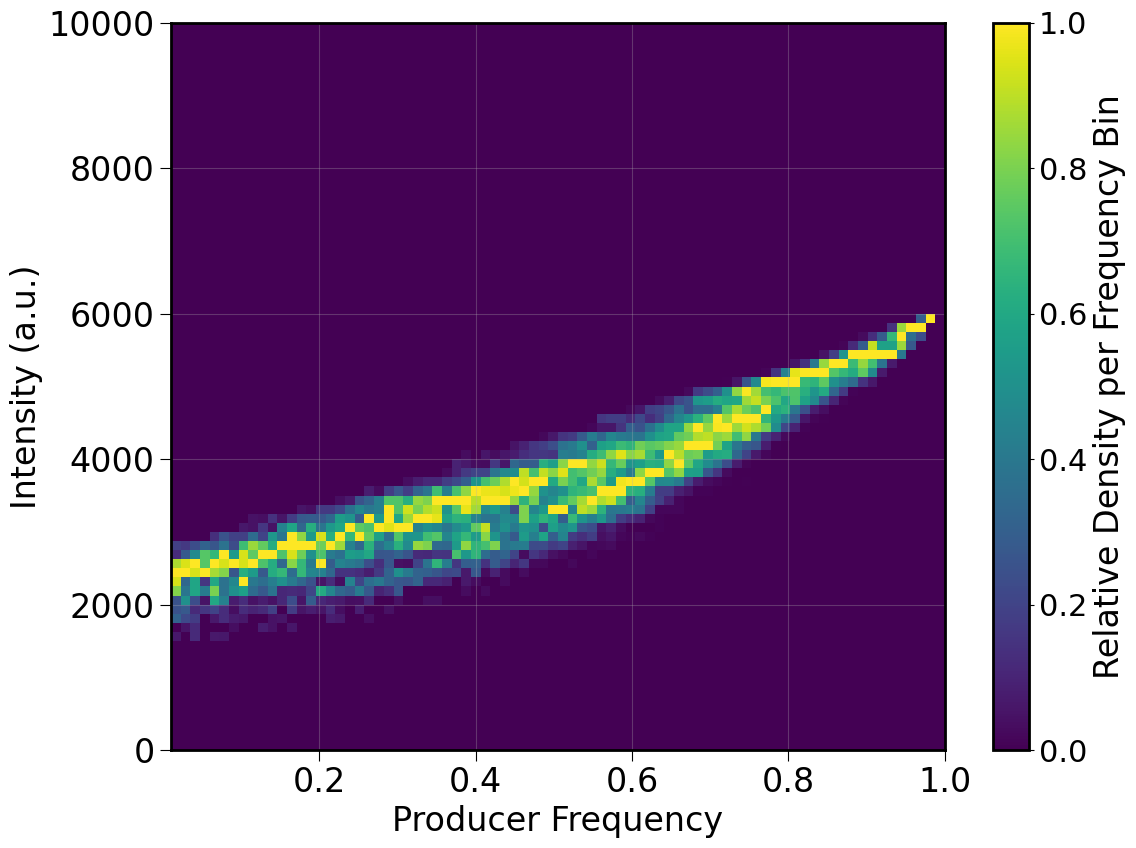

Found 1 xylose concentrations: 1
Found 1 IPTG concentrations: 1
Reading data from ./Xylose1_1IPTG_cropped_cell_info.xlsx
Found 26703 receiver cells, 28073 sender cells in all frames
Processed condition: Xylose 1, IPTG 1
Total valid datapoints collected: 26703

=== Y-axis Limit Selection (Logarithmic Scale) ===
Dataset intensity range: 14.1 to 596.5
Using logarithmic Y-limit: 10^4.0
Saved poster-ready single logarithmic heatmap: SingleHeatmapLog_Poster_..png


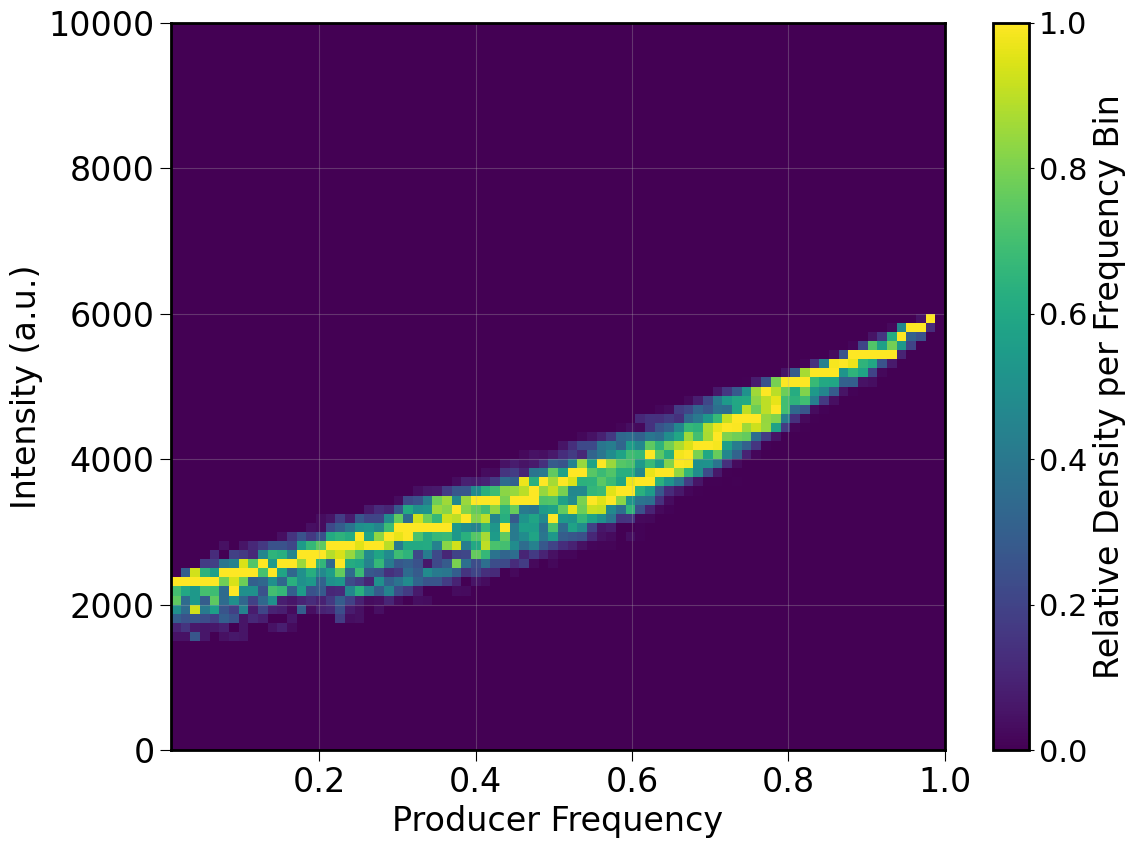

In [64]:
for i in np.arange(0.5, 6, 0.5):
        all_data, conditions = process_folder(".",6, 3,i)

        if all_data is None or len(all_data['frequency']) == 0:
                raise ValueError("Folder contains no valid data")

        create_single_heatmap_log(all_data, conditions, ".")